# Linear mixed effect models

These notes are based on:
Simon Woods book
Douglas Bates

## Introduction

Linear mixed effect models (LMMs; also known as hierarchical or multilevel models) are a commonly used statistical tool in analysis of healthcare data. They are useful in situations where the data is naturally clustered. The clustering unit is usually something XXX such as patients, clinicians or hospitals. A single dataset may contain several clustering units (hereafter levels), giving the data a hierachical structure - patients within clinicians within hospitals. The probabilistic form of the model for vector outcome $\boldsymbol{y}$ is as follows:

$(\boldsymbol{y}|B=b) \sim N(\boldsymbol{X}\boldsymbol{\beta} + \boldsymbol{Z}\boldsymbol{b},\sigma^2 I)$

$\boldsymbol{b} \sim N(\boldsymbol{0},\boldsymbol{\Sigma_{\theta}})$

The $\boldsymbol{X}\boldsymbol{\beta}$ is fixed effect. Here we put covariates. The $\boldsymbol{Z}\boldsymbol{b}$ is the random effect. ...... 

### Examples

#### 1. Random intercepts 

The random effects component $\boldsymbol{Z}\boldsymbol{b}$ often has a very simple structure, such as a unit level deviation from a fixed intercept. For example a model in which each individual $i \in \{1,...,I\}$ is clustered within a hospital $j \in \{1,...,J\}$ and observed at several fixed timepoints $t \in \{1,...,T\}$ would have the following per observation model:

$y_{jit} = X\beta + \mu_i + \mu_j + e_{jit}$

$\mu_i \sim N(0,)$

$\mu_j \sim N(0,)$

$e_{jit} \sim N(0,)$

From this we see that LMMs (as commonly used) are equivalent to decomposing unexplained variation into a per level term and enabling a per level intercept. Unlike adding in a 

#### 2. Random intercepts and slopes

random slopes...

We might consider the assumption that the model is linear quite strong. While we can consider $X$ a basis that may be a transformation of the original data (Bishop), using splines, we may might to use a model that will learn non-linearities as part of the model training. Deep neural networks are one approch to this problem. However, before we consider this lets look at the estimation of LMMs using maximum likelihood.

## Estimation

To cover:

- maximum likelihood (
- bayesian

### Maximum likelihood

y is length n.  

b is length q.

Letting $\Vert x \Vert$

Some distributions are:

$f(y|b,\beta) = (2\pi)^{-n/2}|I\sigma^2|^{-1/2}\text{exp}\{\Vert y-X\beta-Zb\Vert/2\sigma^2\}$

$f(b) = (2\pi)^{-p/2}|\Sigma_{\theta}|^{-1/2}\text{exp}\{-b^t\Sigma_{\theta}^{-1}b/2\}$

Now consider integrating out the random effects since they are "missing". Best over whatever b.

$f(y) = \int f(y,b) db = \int \text{exp}\{\text{log}f(y,b)\} db$ 

This is laplace type integral. We can Taylor expand about the MLEs for b, hat(B), with no remainder terms. THis gives

$f(y) = \int \text{exp}\{\text{log}f(y,\hat{b})\} + 1/2(b-b)\frac{d2 log f(y,\hat{b})}{db db}(b-b) db$ 

Rearrange:

$f(y) = f(y,\hat{b}) \int \text{exp}\{1/2(b-b)\frac{d2 log f(y,\hat{b})}{db db}(b-b) db$

Follow ?Bates and let $B = \Lambda_{\theta} U$ where $U \sim N(0,\sigma)$ then

....


This is a multivariate normal without normalising constant and so integrates to TERM giving

$f(y) = f(y,\hat{b})TERM = f(y|b)f(b)TERM$

The log likelihood (or twice to remove the 1/2) is then:

mse + btb + log(det)

Where mse = ... then penalised residual sum of squares

L'L = ZZ + I the cholesky decompositions.

Estimation proceeds as:

Initialise $\theta$...

1. for current estimates of $\theta^{k-1}$ solve PRR for beta and b to get beta(k) and b(k)
2. set sigma = ...
3. Treating b, beta, sigma as maximise ... for theta.

Steps 1 and 2 can be solved analytically but step 3 requires use of a numerical optimisaiton algorithm such as Nelder-Mead BDFGS..

Some code to illustrate is shown below:

The implementations differ in whether they:

1. Take advantage of sparsity
2. Reuse matrix decompositions
3. Use spherical random effects

In [1]:
## libraries
# linear algebra
using LinearAlgebra, SparseArrays
# plotting
using Plots
# optimisation
using Optim, NLSolversBase, Random
import NLopt, Statistics

In [2]:
# generate data
N, n, p = 20, 1000, 100
ids = repeat(1:n,inner=N)
X = [repeat([1.0],N*n) randn(N*n,p)]
β = randn(p+1)
θ2 = 3.0
b = sqrt(θ2) .* randn(n)
Z = sparse(kron(sparse(1I, n, n),repeat([1],N)))
y = X * β + Z * b + randn(N*n);
print("number of rows: ",length(y))

number of rows: 20000

In [3]:
Statistics.mean(y[ids .== 1])

-1.9395774021402665

In [4]:
means = zeros(n)
for i in 1:n
    means[i] = Statistics.mean(y[ids .== i])
end
Statistics.var(means)

9.083391506744068

### Method 1

In [5]:
# based on standard formulation, y = X\beta + Zb
# b ~ N()
# Y|B=b ~ N()

In [6]:
# use optim
function dev1(X,Z,y,logθ)
    θ_ = exp.(logθ)
    Nn = length(y)
    n = size(Z)[2]
    p = (size(X)[2]-1)
    M = [X Z]
    LL = 1/θ_[1]*transpose(M)*M + diagm([repeat([0.0],(p+1));repeat([1/θ_[2]],n)])
    rr = 1/θ_[1]*transpose(M)*y
    βb_ = LL \ rr
    β_ = βb_[1:(p+1)]
    b_ = βb_[(p+2):end]
    logdetθ = logdet(cholesky(1/θ_[1]*transpose(Z)*Z + 1/θ_[2]*I))
    m2l = (1/θ_[1])*sum((y - M*βb_).^2) + (1/θ_[2])*sum(b_.^2)+ 2*logdetθ  + n*log(θ_[2]) + N*n*log(θ_[1])
    m2l
end

dev1 (generic function with 1 method)

In [7]:
dev1(X,Z,y,log.([1.0,3.0]));
@time dev1(X,Z,y,log.([1.0,3.0]))

  0.836324 seconds (24.75 k allocations: 277.307 MiB, 9.01% gc time, 3.75% compilation time)


27100.47896208406

estimate: [2.0]


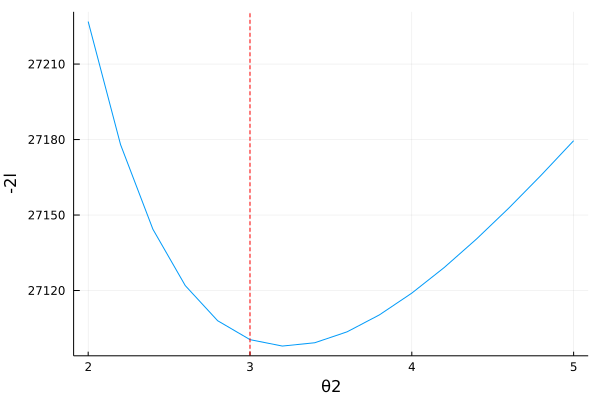

In [8]:
θ2s = range(2.0,5.0,step=0.2)
m2l = zeros(length(θ2s))
for i in 1:length(θ2s)
    m2l[i] = dev1(X,Z,y,log.([1.0,θ2s[i]]))
end
println("estimate: ",θ2s[m2l .== maximum(m2l)])
plot(θ2s,m2l,legend=false,xlabel="θ2",ylabel="-2l")
vline!([θ2],color=:red,linestyle=:dash,legend=false)

In [9]:
@time res = Optim.optimize(var -> dev1(X,Z,y,var), log.([1.0,3.0]),g_tol=0.1)
println(res)
println(exp.(Optim.minimizer(res)))

 21.156703 seconds (6.64 M allocations: 6.521 GiB, 7.66% gc time, 10.32% compilation time)
 * Status: success

 * Candidate solution
    Final objective value:     2.707604e+04

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-01

 * Work counters
    Seconds run:   16  (vs limit Inf)
    Iterations:    10
    f(x) calls:    23

[1.0523399782540235, 3.266505129088487]


### Method 2

In [10]:
# based on standard formulation, y = X\beta + Zb
# b ~ N()
# Y|B=b ~ N()

In [11]:
function dev2(X,XtX,Z,ZtZ,XtZ,y,logθ)
           θ_ = exp.(logθ)
           Nn = length(y)
           n = size(Z)[2]
            p = (size(X)[2]-1)
           MtM = [[XtX XtZ];[transpose(XtZ) ZtZ]]
           M = [X Z]
           LL = 1/θ_[1]*MtM + diagm([repeat([0.0],(p+1));repeat([1/θ_[2]],n)])
           rr = 1/θ_[1]*transpose(M)*y
           βb_ = LL \ rr
           β_ = βb_[1:(p+1)]
           b_ = βb_[(p+2):end]
           logdetθ = logdet(cholesky(1/θ_[1]*ZtZ + 1/θ_[2]*I))
           m2l = (1/θ_[1])*sum((y - M*βb_).^2) + (1/θ_[2])*sum(b_.^2)+ 2*logdetθ  + n*log(θ_[2]) + N*n*log(θ_[1])
           m2l
       end

dev2 (generic function with 1 method)

In [12]:
XtX = transpose(X)*X
ZtZ = transpose(Z)*Z
XtZ = transpose(X)*Z

dev2(X,XtX,Z,ZtZ,XtZ,y,log.([1.0,3.0]));
@time dev2(X,XtX,Z,ZtZ,XtZ,y,log.([1.0,3.0]))

  0.483050 seconds (143 allocations: 211.947 MiB, 5.65% gc time)


27100.478962084057

In [13]:
@time res = Optim.optimize(var -> dev2(X,XtX,Z,ZtZ,XtZ,y,var), log.([1.0,3.0]),g_tol=0.1)
println(res)
println(exp.(Optim.minimizer(res)))

 11.218752 seconds (1.11 M allocations: 4.826 GiB, 6.13% gc time, 4.98% compilation time)
 * Status: success

 * Candidate solution
    Final objective value:     2.707604e+04

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-01

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    10
    f(x) calls:    23

[1.0523399782540235, 3.266505129088487]


### Method 3

In [14]:
# based on standard formulation, y = X\beta + Zb
# b ~ N()
# Y|B=b ~ N()

In [15]:
function dev3(X,XtX,Z,ZtZ,XtZ,y,logθ,n_levels)
           θ_ = exp.(logθ)
           Nn = length(y)
           n = size(Z)[2]
           p = (size(X)[2]-1)
           MtM = [[XtX XtZ];[transpose(XtZ) ZtZ]]
           M = [X Z]
           LL = 1/θ_[1]*MtM + diagm([repeat([0.0],(p+1));repeat([1/θ_[2]],n)])
           rr = 1/θ_[1]*transpose(M)*y
           βb_ = LL \ rr
           β_ = βb_[1:(p+1)]
           b_ = βb_[(p+2):end]
           logdetθ = sum(log.((1/θ_[1])*n_levels .+ (1/θ_[2])))
           m2l = (1/θ_[1])*sum((y - M*βb_).^2) + (1/θ_[2])*sum(b_.^2)+ 2*logdetθ  + n*log(θ_[2]) + N*n*log(θ_[1])
           m2l
       end

dev3 (generic function with 1 method)

In [16]:
n_levels = repeat([N],n);

In [17]:
dev3(X,XtX,Z,ZtZ,XtZ,y,log.([1.0,3.0]),n_levels);
@time dev3(X,XtX,Z,ZtZ,XtZ,y,log.([1.0,3.0]),n_levels)

  0.183738 seconds (104 allocations: 211.693 MiB, 11.47% gc time)


27100.478962083984

In [18]:
@time res = Optim.optimize(var -> dev3(X,XtX,Z,ZtZ,XtZ,y,var,n_levels), log.([1.0,3.0]),g_tol=0.01)
println(res)
println(exp.(Optim.minimizer(res)))

 15.478292 seconds (1.11 M allocations: 6.681 GiB, 6.74% gc time, 3.68% compilation time)
 * Status: success

 * Candidate solution
    Final objective value:     2.707592e+04

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-02

 * Work counters
    Seconds run:   13  (vs limit Inf)
    Iterations:    15
    f(x) calls:    32

[1.0501307840672454, 3.21964617847607]


In [19]:
function fdev3(var::Vector,grad::Vector)
    if (length(grad) > 0)
        
    end
    dev3(X,XtX,Z,ZtZ,XtZ,y,var,n_levels)
end
fdev3(log.([1.0,3.0]),[])

27100.478962083984

In [20]:
opt = NLopt.Opt(:LN_NELDERMEAD, 2)
opt.min_objective = fdev3
opt.ftol_rel = 0.01
@time (minf,minx,ret) = NLopt.optimize(opt,log.([1.0,3.0]))
minx = exp.(minx)
numevals = opt.numevals
println("got $minf at $minx after $numevals iterations (returned $ret)")

  5.776062 seconds (2.38 k allocations: 2.274 GiB, 7.27% gc time, 0.28% compilation time)
got 27100.478962083984 at [1.0, 3.0000000000000004] after 11 iterations (returned FTOL_REACHED)


In [21]:
opt = NLopt.Opt(:LN_BOBYQA, 2)
opt.min_objective = fdev3
opt.ftol_rel = 0.01
@time (minf,minx,ret) = NLopt.optimize(opt,log.([1.0,3.0]))
minx = exp.(minx)
numevals = opt.numevals
println("got $minf at $minx after $numevals iterations (returned $ret)")

  4.043573 seconds (837 allocations: 1.654 GiB, 6.92% gc time)
got 27078.56747048579 at [1.0681937648788065, 3.258206893266905] after 8 iterations (returned FTOL_REACHED)


### Method 4

In [22]:
# based on Bates spherical RE formulation, y = X\beta + Z\Lambda u
# u ~ N(0,sigmaI)
# Y|B=b ~ N()

In [23]:
function dev4(X,Z,y,logθ2)
    θ2 = exp.(logθ2)[1]
    θ1 = 1.0
    Nn = length(y)
    n = size(Z)[2]
    p = (size(X)[2]-1)
    ϕθ = Matrix(θ1*I,N*n,N*n) # noise ~ N(0,Λθ)
    Λθ = Matrix(sqrt(θ2)*I,n,n)  # b ~ N(0,ϕθ)
    D = [[transpose(Λθ)*transpose(Z)*Z*Λθ + I transpose(Λθ)*transpose(Z)*X]; [transpose(X)*Z*Λθ transpose(X)*X]]
    yy = [transpose(Λθ)*transpose(Z)*y; transpose(X)*y];
    uβ_ = D \ yy
    u_ = uβ_[1:n]
    β_ = uβ_[(n+1):end]
    rr = sum((y - X*β_ - Z*Λθ*u_).^2) + sum(u_ .^2)
    logdet(transpose(Λθ)*transpose(Z)*Z*Λθ + I) + Nn*(1 + log((2*pi*rr)/(Nn)))
end

dev4 (generic function with 1 method)

In [24]:
dev4(X,Z,y,log.([3.0]));
@time dev4(X,Z,y,log.([3.0]))

  3.483700 seconds (71 allocations: 3.815 GiB, 27.69% gc time)


60845.74587216641

estimate: [2.0]


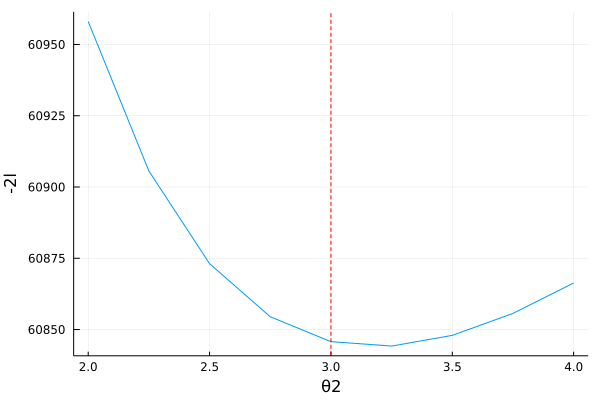

In [25]:
θ2s = range(2,4.0,step=0.25)
m2l = zeros(length(θ2s))
for i in 1:length(θ2s)
    m2l[i] = dev4(X,Z,y,log.([θ2s[i]]))
end
println("estimate: ",θ2s[m2l .== maximum(m2l)])
plot(θ2s,m2l,legend=false,xlabel="θ2",ylabel="-2l")
vline!([θ2],color=:red,linestyle=:dash,legend=false)

In [26]:
@time res = Optim.optimize(var -> dev4(X,Z,y,var), 0.0, 5.0)
println(res)
println(exp.(Optim.minimizer(res)))

 38.336154 seconds (6.32 M allocations: 46.119 GiB, 28.00% gc time, 6.45% compilation time)
Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [0.000000, 5.000000]
 * Minimizer: 1.159154e+00
 * Minimum: 6.084403e+04
 * Iterations: 11
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 12
3.1872355771633134


In [27]:
function fdev4(var::Vector,grad::Vector)
    if (length(grad) > 0)
        
    end
    dev4(X,Z,y,var)
end
fdev4(log.([3.0]),[])

60845.74587216641

In [28]:
opt = NLopt.Opt(:LN_BOBYQA, 1)
opt.min_objective = fdev4
opt.ftol_rel = 0.01
@time (minf,minx,ret) = NLopt.optimize(opt,log.([3.0]))
minx = exp.(minx)
numevals = opt.numevals
println("got $minf at $minx after $numevals iterations (returned $ret)")

 14.081755 seconds (1.49 k allocations: 19.076 GiB, 29.91% gc time, 0.03% compilation time)
got 60844.12039342744 at [3.232401733190206] after 5 iterations (returned FTOL_REACHED)


### Method 5

In [29]:
# based on Bates spherical RE formulation, y = X\beta + Z\Lambda u
# u ~ N(0,sigmaI)
# Y|B=b ~ N()

In [30]:
function dev5(X,Z,y,logθ2)
    θ2 = exp.(logθ2)[1]
    θ1 = 1.0
    Nn = length(y)
    n = size(Z)[2]
    p = (size(X)[2]-1)
    ϕθ = Matrix(θ1*I,N*n,N*n) # noise ~ N(0,Λθ)
    Λθ = Matrix(sqrt(θ2)*I,n,n)  # b ~ N(0,ϕθ)
    D = [[transpose(Λθ)*transpose(Z)*Z*Λθ + I transpose(Λθ)*transpose(Z)*X]; [transpose(X)*Z*Λθ transpose(X)*X]]
    Dchol = cholesky(Symmetric(D))
    yy = [transpose(Λθ)*transpose(Z)*y; transpose(X)*y];
    uβ_ = Dchol \ yy
    u_ = uβ_[1:n]
    β_ = uβ_[(n+1):end]
    rr = sum((y - X*β_ - Z*Λθ*u_).^2) + sum(u_ .^2)
    2*sum(log.(diag(Dchol.L[1:n,1:n]))) + Nn*(1 + log((2*pi*rr)/(Nn)))
end

dev5 (generic function with 1 method)

In [31]:
dev5(X,Z,y,log.([3.0]));
@time dev5(X,Z,y,log.([3.0]))

  1.965966 seconds (68 allocations: 3.653 GiB, 29.54% gc time)


60845.74587216641

estimate: [2.0]


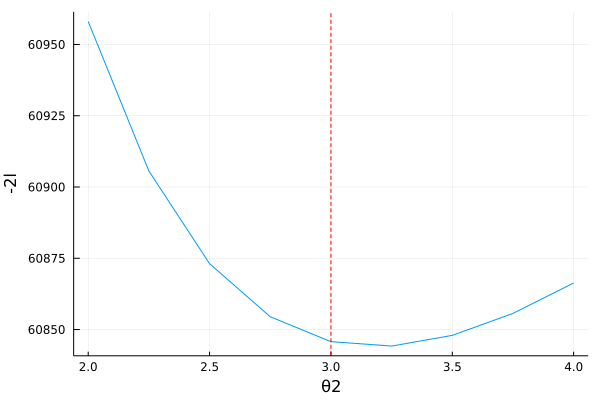

In [32]:
θ2s = range(2,4.0,step=0.25)
m2l = zeros(length(θ2s))
for i in 1:length(θ2s)
    m2l[i] = dev5(X,Z,y,log.([θ2s[i]]))
end
println("estimate: ",θ2s[m2l .== maximum(m2l)])
plot(θ2s,m2l,legend=false,xlabel="θ2",ylabel="-2l")
vline!([θ2],color=:red,linestyle=:dash,legend=false)

In [33]:
function fdev5(var::Vector,grad::Vector)
    if (length(grad) > 0)
        
    end
    dev5(X,Z,y,var)
end
fdev5(log.([3.0]),[])

60845.74587216641

In [34]:
opt = NLopt.Opt(:LN_BOBYQA, 1)
opt.min_objective = fdev5
opt.ftol_rel = 0.01
@time (minf,minx,ret) = NLopt.optimize(opt,log.([3.0]))
minx = exp.(minx)
numevals = opt.numevals
println("got $minf at $minx after $numevals iterations (returned $ret)")

  9.545044 seconds (1.48 k allocations: 18.264 GiB, 27.88% gc time, 0.05% compilation time)
got 60844.12039342739 at [3.2324017331897346] after 5 iterations (returned FTOL_REACHED)


### Method 6

In [35]:
# based on Bates spherical RE formulation, y = X\beta + Z\Lambda u
# u ~ N(0,sigmaI)
# Y|B=b ~ N()

In [90]:
function dev6(X,XtX,Z,ZtZ,XtZ,y,logθ2)
    θ2 = exp.(logθ2)[1]
    θ1 = 1.0
    Nn = length(y)
    n = size(Z)[2]
    p = (size(X)[2]-1)
    ϕθ = sparse(θ1*I,N*n,N*n) # noise ~ N(0,Λθ)
    Λθ = sparse(sqrt(θ2)*I,n,n)  # b ~ N(0,ϕθ)
    D = [[transpose(Λθ)*ZtZ*Λθ + I transpose(Λθ)*transpose(XtZ)]; [XtZ*Λθ XtX]]
    Dchol = cholesky(D,perm=1:size(D)[1])
    yy = [transpose(Λθ)*transpose(Z)*y; transpose(X)*y]
    uβ_ = Dchol \ yy
    u_ = uβ_[1:n]
    β_ = uβ_[(n+1):end]
    rr = sum((y - X*β_ - Z*Λθ*u_).^2) + sum(u_ .^2)
    2*sum(log.(diag(sparse(Dchol.L)[1:n,1:n]))) + Nn*(1 + log((2*pi*rr)/(Nn)))
end

dev6 (generic function with 1 method)

In [92]:
dev6(X,XtX,Z,ZtZ,XtZ,y,log.([3.0]));
@time dev6(X,XtX,Z,ZtZ,XtZ,y,log.([9.0]))

  0.967563 seconds (291 allocations: 474.760 MiB, 38.06% gc time)


2.899412591367423e6

In [38]:
function fdev6(var::Vector,grad::Vector)
    if (length(grad) > 0)
        
    end
    dev6(X,XtX,Z,ZtZ,XtZ,y,var)
end
fdev6(log.([3.0]),[])

60845.74587216641

In [39]:
opt = NLopt.Opt(:LN_BOBYQA, 1)
opt.min_objective = fdev6
opt.ftol_rel = 0.00001
@time (minf,minx,ret) = NLopt.optimize(opt,log.([9.0]))
minx = exp.(minx)
numevals = opt.numevals
println("got $minf at $minx after $numevals iterations (returned $ret)")

  0.493171 seconds (3.42 k allocations: 338.319 MiB, 8.24% gc time, 0.92% compilation time)
got 60844.13952621657 at [3.2369781232010424] after 9 iterations (returned FTOL_REACHED)


### Method 7

In [40]:
# based on Bates spherical RE formulation, y = X\beta + Z\Lambda u
# u ~ N(0,sigmaI)
# Y|B=b ~ N()

In [87]:
function dev7(X,XtX,Z,ZtZ,XtZ,y,logθ2)
    θ2 = exp.(logθ2)[1]
    #θ1 = 1.0
    Nn = length(y)
    n = size(Z)[2]
    p = (size(X)[2]-1)
    D = [[θ2*ZtZ + I sqrt(θ2)*transpose(XtZ)]; [XtZ*sqrt(θ2) XtX]]
    Dchol = cholesky(D,perm=1:size(D)[1])
    yy = [sqrt(θ2)*transpose(Z)*y; transpose(X)*y]
    uβ_ = Dchol \ yy
    u_ = uβ_[1:n]
    β_ = uβ_[(n+1):end]
    rr = sum((y - X*β_ - Z*sqrt(θ2)*u_).^2) + sum(u_ .^2)
    2*sum(log.(diag(sparse(Dchol.L)[1:n,1:n]))) + Nn*(1 + log((2*pi*rr)/(Nn)))
end

dev7 (generic function with 1 method)

In [89]:
dev7(X,XtX,Z,ZtZ,XtZ,y,log.([3.0]));
@time dev7(X,XtX,Z,ZtZ,XtZ,y,log.([3.0]))

  0.907043 seconds (245 allocations: 431.174 MiB, 35.54% gc time)


2.895189689481789e6

In [43]:
function fdev7(var::Vector,grad::Vector)
    if (length(grad) > 0)
        
    end
    dev7(X,XtX,Z,ZtZ,XtZ,y,var)
end
fdev7(log.([3.0]),[])

60845.74587216641

In [44]:
opt = NLopt.Opt(:LN_BOBYQA, 1)
opt.min_objective = fdev7
opt.ftol_rel = 0.01
@time (minf,minx,ret) = NLopt.optimize(opt,log.([2.9]))
minx = exp.(minx)
numevals = opt.numevals
println("got $minf at $minx after $numevals iterations (returned $ret)")

  0.254685 seconds (2.25 k allocations: 183.045 MiB, 5.95% gc time, 1.63% compilation time)
got 60844.057613542915 at [3.2122251692731627] after 5 iterations (returned FTOL_REACHED)


### Method 8

In [45]:
# based on Bates spherical RE formulation, y = X\beta + Z\Lambda u
# u ~ N(0,sigmaI)
# Y|B=b ~ N()

In [46]:
logθ2

LoadError: UndefVarError: logθ2 not defined

In [84]:
function dev8(X,XtX,Z,ZtZ,XtZ,y,logθ2,n_levels,uβ_)
    θ2 = exp.(logθ2)[1]
    #θ1 = 1.0
    Nn = length(y)
    n = size(Z)[2]
    p = (size(X)[2]-1)
    D = [[θ2*ZtZ + I sqrt(θ2)*transpose(XtZ)]; [XtZ*sqrt(θ2) XtX]]
    #Dchol = cholesky(D,perm=1:size(D)[1])
    yy = [sqrt(θ2)*transpose(Z)*y; transpose(X)*y]
    uβ_[1:end] = D \ yy
    u_ = uβ_[1:n]
    β_ = uβ_[(n+1):end]
    rr = sum((y - X*β_ - Z*sqrt(θ2)*u_).^2) + sum(u_ .^2)
    logdetθ = sum(log.(θ2*n_levels .+ 1.0))
    logdetθ + Nn*(1 + log((2*pi*rr)/(Nn)))
end

dev8 (generic function with 1 method)

In [86]:
uβ_ = zeros(n+p+1)
dev8(X,XtX,Z,ZtZ,XtZ,y,log.([3.0]),n_levels,uβ_);
@time dev8(X,XtX,Z,ZtZ,XtZ,y,log.([3.0]),n_levels,uβ_)
#    0.923071 seconds (179 allocations: 398.214 MiB, 41.06% gc time)

  0.854452 seconds (179 allocations: 398.214 MiB, 37.41% gc time)


2.895189689481789e6

In [72]:
function fdev8(var::Vector,grad::Vector)
    if (length(grad) > 0)
        
    end
    dev8(X,XtX,Z,ZtZ,XtZ,y,var,n_levels,uβ_)
end
fdev8(log.([3.0]),[])

2.895189689481789e6

In [77]:
uβ_ = zeros(n+p+1)
opt = NLopt.Opt(:LN_BOBYQA, 1)
opt.min_objective = fdev8
opt.ftol_rel = 0.000001
@time (minf,minx,ret) = NLopt.optimize(opt,log.([9.0]))
minx = exp.(minx)
numevals = opt.numevals
println("got $minf at $minx after $numevals iterations (returned $ret)")

  9.916753 seconds (2.15 k allocations: 4.667 GiB, 38.24% gc time)
got 2.8951899476614934e6 at [2.992351639689909] after 12 iterations (returned FTOL_REACHED)


In [78]:
size(X)

(1000000, 101)

In [52]:
# generate bigger data
N, n, p = 100, 10000, 100
X = [repeat([1.0],N*n) randn(N*n,p)]
β = randn(p+1)
θ2 = 3.0
b = sqrt(θ2) .* randn(n)
Z = sparse(kron(sparse(1I, n, n),repeat([1],N)))
y = X * β + Z * b + randn(N*n);
n_levels = repeat([N],n);
println("number of rows: ",length(y))
println("dim X: ",size(X))
println("dim Z: ",size(Z))

XtX = transpose(X)*X;
ZtZ = transpose(Z)*Z;
XtZ = transpose(X)*Z;

number of rows: 1000000
dim X: (1000000, 101)
dim Z: (1000000, 10000)


In [53]:
#dev8(X,XtX,Z,ZtZ,XtZ,y,log.([3.0]),n_levels);
@time dev8(X,XtX,Z,ZtZ,XtZ,y,log.([3.0]),n_levels)

LoadError: MethodError: no method matching dev8(::Matrix{Float64}, ::Matrix{Float64}, ::SparseMatrixCSC{Int64, Int64}, ::SparseMatrixCSC{Int64, Int64}, ::Matrix{Float64}, ::Vector{Float64}, ::Vector{Float64}, ::Vector{Int64})
[0mClosest candidates are:
[0m  dev8(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, [91m::Any[39m) at In[47]:1

In [54]:
function fdev8(var::Vector,grad::Vector)
    if (length(grad) > 0)
        
    end
    dev8(X,XtX,Z,ZtZ,XtZ,y,var,n_levels)
end
fdev8(log.([3.0]),[])

LoadError: MethodError: no method matching dev8(::Matrix{Float64}, ::Matrix{Float64}, ::SparseMatrixCSC{Int64, Int64}, ::SparseMatrixCSC{Int64, Int64}, ::Matrix{Float64}, ::Vector{Float64}, ::Vector{Float64}, ::Vector{Int64})
[0mClosest candidates are:
[0m  dev8(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, [91m::Any[39m) at In[47]:1

In [55]:
opt = NLopt.Opt(:LN_BOBYQA, 1)
opt.min_objective = fdev8
opt.ftol_rel = 0.0000001
@time (minf,minx,ret) = NLopt.optimize(opt,log.([2.9]))
minx = exp.(minx)
numevals = opt.numevals
println("got $minf at $minx after $numevals iterations (returned $ret)")

  0.032514 seconds (1.20 k allocations: 77.812 KiB, 13.13% compilation time)
got 0.0 at [2.9] after 1 iterations (returned FORCED_STOP)


### Method 9

In [116]:
function dev9(D,yy,X,Z,y,logθ2,n_levels,uβ_)
    θ2 = exp.(logθ2)[1]
    #θ1 = 1.0
    Nn = length(y)
    n = size(Z)[2]
    p = (size(X)[2]-1)
    #D = [[θ2*ZtZ sqrt(θ2)*transpose(XtZ)]; [XtZ*sqrt(θ2) XtX]]
    D[1:n,1:n] = θ2*D[1:n,1:n] + I
    D[1:n,(n+1):end] = sqrt(θ2)*D[1:n,(n+1):end]
    D[(n+1):end,(n+1):end] = sqrt(θ2)*D[(n+1):end,(n+1):end]
    #Dchol = cholesky(D,perm=1:size(D)[1])
    yy[1:n] = sqrt(θ2)*yy[1:n]
    uβ_[1:(n+p+1)] = D \ yy
    u_ = @view uβ_[1:n]
    β_ = @view uβ_[(n+1):end]
    rr = sum((y - X*β_ - Z*sqrt(θ2)*u_).^2) + sum(u_ .^2)
    logdetθ = sum(log.(θ2*n_levels .+ 1.0))
    logdetθ + Nn*(1 + log((2*pi*rr)/(Nn)))
end

dev9 (generic function with 2 methods)

In [117]:
logθ2 = log.([3.0])
θ2 = exp.(logθ2)[1]
D = [[ZtZ transpose(XtZ)]; [XtZ XtX]]
yy = [transpose(Z)*y; transpose(X)*y]
uβ_ = zeros(n+p+1)
dev9(D,yy,X,Z,y,log.([3.0]),n_levels,uβ_)
@time dev9(D,yy,X,Z,y,log.([3.0]),n_levels,uβ_)

  0.980979 seconds (173 allocations: 350.333 MiB, 30.28% gc time)


6.801102251760842e6

In [58]:
function fdev9(var::Vector,grad::Vector)
    if (length(grad) > 0)
        
    end
    dev9(D,yy,X,Z,y,var,n_levels)
end
fdev9(log.([2.9]),[])

6.784274790794368e6

In [59]:
opt = NLopt.Opt(:LN_BOBYQA, 1)
opt.min_objective = fdev9
opt.ftol_rel = 0.0000001
@time (minf,minx,ret) = NLopt.optimize(opt,log.([2.9]))
minx = exp.(minx)
numevals = opt.numevals
println("got $minf at $minx after $numevals iterations (returned $ret)")

 66.116941 seconds (25.86 k allocations: 30.798 GiB, 3.71% gc time, 0.03% compilation time)
got 7.178124028709893e6 at [2.9] after 90 iterations (returned ROUNDOFF_LIMITED)


### Julia's Mixed Models

In [60]:
using MixedModels, DataFrames

In [61]:
df = convert(DataFrame, [y X repeat(1:n,inner=N)]);
categorical!(df, :x103);
select!(df, Not(:x2));

In [62]:
# f = "x3"
# vars = "x" .* string.(4:102)
# for i in 1:99
#     f = f .* "+" .* vars[i]
# end
# #println(f)
# f = f .* "+(1|x103)"
# Meta.parse(f)
# #@eval(@formula(Meta.parse(f)))

In [63]:
#lhs = Meta.parse(f)
# 
m1 = fit(MixedModel, @formula(x1 ~ x3 + x4 + x5 + x6 + x7 + x8 + x9 + x10 + x11 + x12 + x13 + x14 + x15 + x16 + x17 + x18 + x19 + x20 + x21 + x22 + x23 + x24 + x25 + x26 + x27 + x28 + x29 + x30 + x31 + x32 + x33 + x34 + x35 + x36 + x37 + x38 + x39 + x40 + x41 + x42 + x43 + x44 + x45 + x46 + x47 + x48 + x49 + x50 + x51 + x52 + x53 + x54 + x55 + x56 + x57 + x58 + x59 + x60 + x61 + x62 + x63 + x64 + x65 + x66 + x67 + x68 + x69 + x70 + x71 + x72 + x73 + x74 + x75 + x76 + x77 + x78 + x79 + x80 + x81 + x82 + x83 + x84 + x85 + x86 + x87 + x88 + x89 + x90 + x91 + x92 + x93 + x94 + x95 + x96 + x97 + x98 + x99 + x100 + x101 + x102 + (1 | x103)), df);

 77.872797 seconds (75.33 M allocations: 11.156 GiB, 5.15% gc time, 2.05% compilation time)


In [79]:
@time m1 = fit(MixedModel, @formula(x1 ~ x3 + x4 + x5 + x6 + x7 + x8 + x9 + x10 + x11 + x12 + x13 + x14 + x15 + x16 + x17 + x18 + x19 + x20 + x21 + x22 + x23 + x24 + x25 + x26 + x27 + x28 + x29 + x30 + x31 + x32 + x33 + x34 + x35 + x36 + x37 + x38 + x39 + x40 + x41 + x42 + x43 + x44 + x45 + x46 + x47 + x48 + x49 + x50 + x51 + x52 + x53 + x54 + x55 + x56 + x57 + x58 + x59 + x60 + x61 + x62 + x63 + x64 + x65 + x66 + x67 + x68 + x69 + x70 + x71 + x72 + x73 + x74 + x75 + x76 + x77 + x78 + x79 + x80 + x81 + x82 + x83 + x84 + x85 + x86 + x87 + x88 + x89 + x90 + x91 + x92 + x93 + x94 + x95 + x96 + x97 + x98 + x99 + x100 + x101 + x102 + (1 | x103)), df);

 29.367561 seconds (813.69 k allocations: 6.194 GiB, 10.77% gc time, 11.11% compilation time)


In [80]:
VarCorr(m1)

|          | Column      |  Variance | Std.Dev |
|:-------- |:----------- | ---------:| -------:|
| x103     | (Intercept) |   3.02745 | 1.73996 |
| Residual |             |   1.00015 | 1.00008 |


In [65]:
?MixedModel

search: MixedModel MixedModels MixedModelBootstrap LinearMixedModel



```
MixedModel
```

Abstract type for mixed models.  MixedModels.jl implements two subtypes: `LinearMixedModel` and `GeneralizedLinearMixedModel`.  See the documentation for each for more details.

This type is primarily used for dispatch in `fit`.  Without a distribution and link function specified, a `LinearMixedModel` will be fit.  When a distribution/link function is provided, a `GeneralizedLinearModel` is fit, unless that distribution is `Normal` and the link is `IdentityLink`, in which case the resulting GLMM would be equivalent to a `LinearMixedModel` anyway and so the simpler, equivalent `LinearMixedModel` will be fit instead.


## Appendix: Multivariate Gaussian

$U \sim N(0,\sigma^2 I$)

$B = \Lambda(\theta)U \sim N(0,\Lambda(\theta)\Lambda(\theta)^t)$


In [66]:
ll = cholesky(Matrix(1I*2.3, 10, 10)).L

10×10 LowerTriangular{Float64, Matrix{Float64}}:
 1.51658   ⋅        ⋅        ⋅       …   ⋅        ⋅        ⋅        ⋅ 
 0.0      1.51658   ⋅        ⋅           ⋅        ⋅        ⋅        ⋅ 
 0.0      0.0      1.51658   ⋅           ⋅        ⋅        ⋅        ⋅ 
 0.0      0.0      0.0      1.51658      ⋅        ⋅        ⋅        ⋅ 
 0.0      0.0      0.0      0.0          ⋅        ⋅        ⋅        ⋅ 
 0.0      0.0      0.0      0.0      …   ⋅        ⋅        ⋅        ⋅ 
 0.0      0.0      0.0      0.0         1.51658   ⋅        ⋅        ⋅ 
 0.0      0.0      0.0      0.0         0.0      1.51658   ⋅        ⋅ 
 0.0      0.0      0.0      0.0         0.0      0.0      1.51658   ⋅ 
 0.0      0.0      0.0      0.0         0.0      0.0      0.0      1.51658

In [67]:
cholesky(Matrix(1I*2.3, 10, 10)).U

10×10 UpperTriangular{Float64, Matrix{Float64}}:
 1.51658  0.0      0.0      0.0      …  0.0      0.0      0.0      0.0
  ⋅       1.51658  0.0      0.0         0.0      0.0      0.0      0.0
  ⋅        ⋅       1.51658  0.0         0.0      0.0      0.0      0.0
  ⋅        ⋅        ⋅       1.51658     0.0      0.0      0.0      0.0
  ⋅        ⋅        ⋅        ⋅          0.0      0.0      0.0      0.0
  ⋅        ⋅        ⋅        ⋅       …  0.0      0.0      0.0      0.0
  ⋅        ⋅        ⋅        ⋅          1.51658  0.0      0.0      0.0
  ⋅        ⋅        ⋅        ⋅           ⋅       1.51658  0.0      0.0
  ⋅        ⋅        ⋅        ⋅           ⋅        ⋅       1.51658  0.0
  ⋅        ⋅        ⋅        ⋅           ⋅        ⋅        ⋅       1.51658

In [68]:
1/1.51658

0.6593783381028366

In [69]:
sqrt(2.3)

1.51657508881031